# Import Libraries

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns # visualizations
import os
import matplotlib.pyplot as plt
from tqdm import tqdm

# Dataset Loading
read the dataset using the first 10 million rows

In [2]:
df = pd.read_csv('../data/2019-Nov.csv', nrows = 10000000)
df.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2019-11-01 00:00:00 UTC,view,1003461,2053013555631882655,electronics.smartphone,xiaomi,489.07,520088904,4d3b30da-a5e4-49df-b1a8-ba5943f1dd33
1,2019-11-01 00:00:00 UTC,view,5000088,2053013566100866035,appliances.sewing_machine,janome,293.65,530496790,8e5f4f83-366c-4f70-860e-ca7417414283
2,2019-11-01 00:00:01 UTC,view,17302664,2053013553853497655,NaN,creed,28.31,561587266,755422e7-9040-477b-9bd2-6a6e8fd97387
3,2019-11-01 00:00:01 UTC,view,3601530,2053013563810775923,appliances.kitchen.washer,lg,712.87,518085591,3bfb58cd-7892-48cc-8020-2f17e6de6e7f
4,2019-11-01 00:00:01 UTC,view,1004775,2053013555631882655,electronics.smartphone,xiaomi,183.27,558856683,313628f1-68b8-460d-84f6-cec7a8796ef2


### Data types

In [3]:
df.dtypes

event_time        object
event_type        object
product_id         int64
category_id        int64
category_code     object
brand             object
price            float64
user_id            int64
user_session      object
dtype: object

# Data Cleaning 

### Drop Duplicate Values and columns of no use

In [4]:
# check for deplicate rows
df.duplicated().sum()

print(df.shape, 'before dropping duplicates')

# drop duplicates rows
df = df.drop_duplicates()

print(df.shape, 'after dropping duplicates')

(10000000, 9) before dropping duplicates
(9996291, 9) after dropping duplicates


In [5]:
# Drop columns of no use
df = df.drop(['event_time','category_id','user_session'], axis=1)
df.head()

,event_type,product_id,category_code,brand,price,user_id
0,view,1003461,electronics.smartphone,xiaomi,489.07,520088904
1,view,5000088,appliances.sewing_machine,janome,293.65,530496790
2,view,17302664,NaN,creed,28.31,561587266
3,view,3601530,appliances.kitchen.washer,lg,712.87,518085591
4,view,1004775,electronics.smartphone,xiaomi,183.27,558856683


# Customer behavior

## Top 10 brand that most customer purchased vs. view

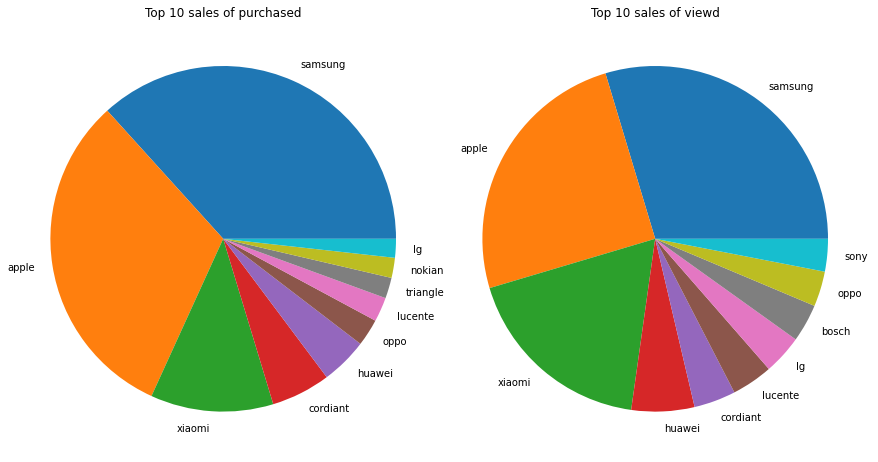

In [6]:
# most customer purchased
purchased = df.loc[df.event_type == 'purchase']
purchases_with_brands = purchased.loc[purchased.brand.notnull()]

purchased_top_sellers = purchases_with_brands.groupby('brand').brand.agg([len]).sort_values(by="len", ascending=False)
purchased_top_sellers.reset_index(inplace=True)
purchased_top_sellers.rename(columns={"len" : "# sales"}, inplace=True)

# most customer view
view = df.loc[df.event_type == 'view']
view_with_brands = view.loc[view.brand.notnull()]

view_top_sellers = view_with_brands.groupby('brand').brand.agg([len]).sort_values(by="len", ascending=False)
view_top_sellers.reset_index(inplace=True)
view_top_sellers.rename(columns={"len" : "# sales"}, inplace=True)

# Visualization
fig = plt.figure()

ax1 = fig.add_axes([0, 0, 1.5, 1.5], aspect=1)
ax1.pie(purchased_top_sellers["# sales"].head(10),labels=purchased_top_sellers["brand"].head(10))

ax2 = fig.add_axes([1, .0, 1.5, 1.5], aspect=1)
ax2.pie(view_top_sellers["# sales"].head(10),labels=view_top_sellers["brand"].head(10))

ax1.set_title('Top 10 sales of purchased')
ax2.set_title('Top 10 sales of viewd')
plt.show()

## Top 10 category that most customer purchased vs. view

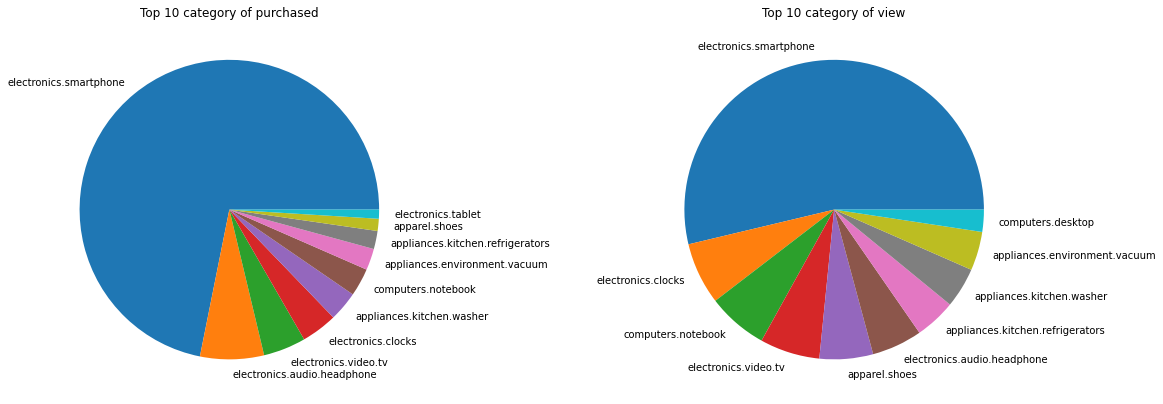

In [7]:
# category that customer purchased
purchased = df.loc[df.event_type == 'purchase']
purchases_category = purchased.loc[purchased.category_code.notnull()]

purchases_top_category = purchases_category.groupby('category_code').category_code.agg([len]).sort_values(by="len", ascending=False)
purchases_top_category.reset_index(inplace=True)
purchases_top_category.rename(columns={"len" : "# sales"}, inplace=True)

# category that customer view
view = df.loc[df.event_type == 'view']
view_category = view.loc[view.category_code.notnull()]

view_top_category = view_category.groupby('category_code').category_code.agg([len]).sort_values(by="len", ascending=False)
view_top_category.reset_index(inplace=True)
view_top_category.rename(columns={"len" : "# sales"}, inplace=True)

# Visualization
fig = plt.figure()

ax1 = fig.add_axes([0, 0, 1.3, 1.3], aspect=1)
ax1.pie(purchases_top_category["# sales"].head(10),labels=purchases_top_category["category_code"].head(10))

ax2 = fig.add_axes([1.4, .0, 1.3, 1.3], aspect=1)
ax2.pie(view_top_category["# sales"].head(10),labels=view_top_category["category_code"].head(10))

ax1.set_title('Top 10 category of purchased')
ax2.set_title('Top 10 category of view')
plt.show()

# Customer purchased activities in Nov

In [11]:
#creating a customer table

#Filtering sales activities
sales_filter = df['event_type']=='purchase'
Customer_table = df.loc[sales_filter].groupby(by=['user_id']).agg(number_of_purchases=
                                                                  ('user_id','count'),total_sales=('price','sum')).reset_index()

In [15]:
#Calculating number of customers who bought something
customers_who_bought_smt = Customer_table['user_id'].nunique()
print('There are {:,.0f} customers, who purchased in Nov.'.format(customers_who_bought_smt))

#Calculationg repeat customers number
more_than_one_purchase_filter = Customer_table['number_of_purchases']>1
customers_who_bought_more_than_once = Customer_table.loc[more_than_one_purchase_filter].shape[0]
print('There are {:,.0f} repeat customers, who bought more than once.'.format(customers_who_bought_more_than_once))

There are 91,226 customers, who purchased in Nov.
There are 25,387 repeat customers, who bought more than once.


### Top 10 users with most puchased activities

In [23]:
customers_with_highest_number_of_purchases = df[sales_filter]
customers_with_highest_number_of_purchases['user_id'].value_counts().head(10)

564068124    319
549109608     54
564769842     53
551801600     50
535327520     50
515644853     49
566195962     48
563889375     47
564133858     46
551140089     45
Name: user_id, dtype: int64

In [27]:
users_activities = df['user_id'] == 551140089
df[users_activities]

,event_type,product_id,category_code,brand,price,user_id
4728909,view,11000156,appliances.kitchen.toster,smeg,181.52,551140089
4729215,view,11000157,appliances.kitchen.toster,smeg,181.52,551140089
4729720,view,1004249,electronics.smartphone,apple,724.60,551140089
4730419,cart,1004249,electronics.smartphone,apple,724.60,551140089
4732646,purchase,1004249,electronics.smartphone,apple,724.60,551140089
...,...,...,...,...,...,...
8679633,purchase,1004246,electronics.smartphone,apple,758.63,551140089
8680287,view,1004246,electronics.smartphone,apple,758.63,551140089
8682710,view,4100232,NaN,sony,592.01,551140089
8683557,purchase,4100232,NaN,sony,592.01,551140089
